# 04 — Préparation à la segmentation

## Répartir la table client finale

In [6]:
from pathlib import Path
import pandas as pd

PROJECT_DIR = Path.cwd().parent
INTERIM_DIR = PROJECT_DIR / "data" / "interim"

client_features = pd.read_parquet(
    INTERIM_DIR / "client_features.parquet"
)


In [7]:
client_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93358 entries, 0 to 93357
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  93358 non-null  object 
 1   recency             93358 non-null  int64  
 2   frequency           93358 non-null  int64  
 3   monetary            93357 non-null  float64
 4   avg_basket          93357 non-null  float64
 5   total_items         93358 non-null  int64  
 6   avg_delivery_delay  93350 non-null  float64
 7   avg_review_score    92755 non-null  float64
 8   nb_categories       93358 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 6.4+ MB


In [8]:
client_features.shape

(93358, 9)

In [9]:
client_features.head()

,customer_unique_id,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,141.90,1,6.0,5.0,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,27.19,1,3.0,4.0,1
2,0000f46a3911fa3c0805444483337064,536,1,86.22,86.22,1,25.0,3.0,1
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,43.62,1,20.0,4.0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,196.89,1,13.0,5.0,1


In [10]:
client_features = client_features.copy()

## Traitement des valeurs manquantes 

In [11]:
client_features["monetary"] = client_features["monetary"].fillna(0)
client_features["avg_basket"] = client_features["avg_basket"].fillna(0)

client_features["avg_review_score"] = (
    client_features["avg_review_score"]
    .fillna(client_features["avg_review_score"].median())
)

client_features["avg_delivery_delay"] = (
    client_features["avg_delivery_delay"]
    .fillna(client_features["avg_delivery_delay"].median())
)

In [12]:
client_features.isna().mean()

customer_unique_id    0.0
recency               0.0
frequency             0.0
monetary              0.0
avg_basket            0.0
total_items           0.0
avg_delivery_delay    0.0
avg_review_score      0.0
nb_categories         0.0
dtype: float64

## Selection des varaibles pour la segmentation

- on segmente sur des comportements pas sur les identifiants

In [13]:
segmentation_vars = [
    "recency",
    "frequency",
    "monetary",
    "avg_basket",
    "total_items",
    "avg_delivery_delay",
    "avg_review_score",
    "nb_categories"
]


## Analyse des distributionss

In [14]:
client_features[segmentation_vars].describe()

,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.00000
mean,236.941773,1.033420,165.197003,160.314930,1.180370,12.102647,4.159135,1.02604
std,152.591453,0.209097,226.314012,219.571513,0.620857,9.551034,1.277734,0.17162
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000
25%,113.000000,1.000000,63.052500,62.370000,1.000000,6.000000,4.000000,1.00000
50%,218.000000,1.000000,107.780000,105.630000,1.000000,10.000000,5.000000,1.00000
75%,345.000000,1.000000,182.557500,176.650000,1.000000,15.000000,5.000000,1.00000
max,713.000000,15.000000,13664.080000,13664.080000,24.000000,209.000000,5.000000,5.00000


## Scaling des varibales

- On ne choisi pas StandardScaler parce qu'il est très sensible aux outliers
- Il ne va pas bien marché sur des données asymétriques vu que mes données le sont

In [15]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_scaled = scaler.fit_transform(client_features[segmentation_vars])

X_scaled = pd.DataFrame(
    X_scaled,
    columns=segmentation_vars,
    index=client_features.index
)


## Vérification post scaling

In [16]:
X_scaled.describe()

,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.00000
mean,0.081646,0.033420,0.480457,0.478517,0.180370,0.233627,-0.840865,0.02604
std,0.657722,0.209097,1.893762,1.921347,0.620857,1.061226,1.277734,0.17162
min,-0.939655,0.000000,-0.901887,-0.924309,0.000000,-1.111111,-4.000000,0.00000
25%,-0.452586,0.000000,-0.374273,-0.378544,0.000000,-0.444444,-1.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.547414,0.000000,0.625727,0.621456,0.000000,0.555556,0.000000,0.00000
max,2.133621,14.000000,113.437095,118.642370,23.000000,22.111111,0.000000,4.00000


## Préparation à la segmentation — Conclusion

Les variables client ont été nettoyées, sélectionnées et mises à l’échelle
à l’aide d’un RobustScaler afin de limiter l’impact des valeurs extrêmes.

La matrice finale est prête pour l’application des algorithmes de clustering.

# 4.2 — Choisir le nombre optimal de clusters


## Méthode du coude (Elbow method)
- on cherhcche le point de rupture avec K-means qui minimise l'inertir intra-cluster

In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)


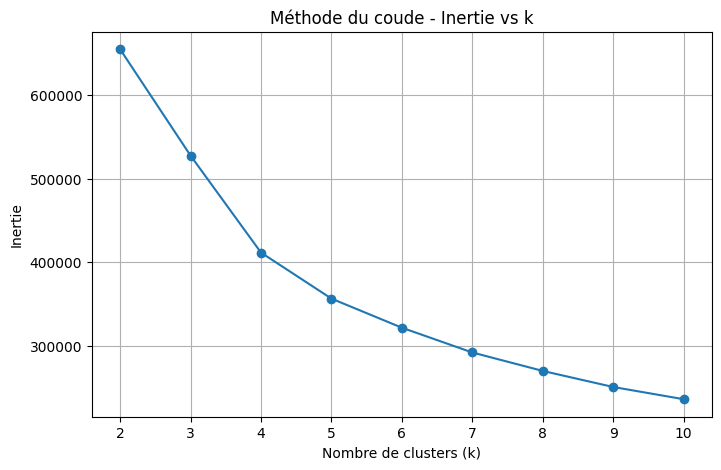

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.title("Méthode du coude - Inertie vs k")
plt.grid(True)
plt.show()


## Score de silhouette

In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in K:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


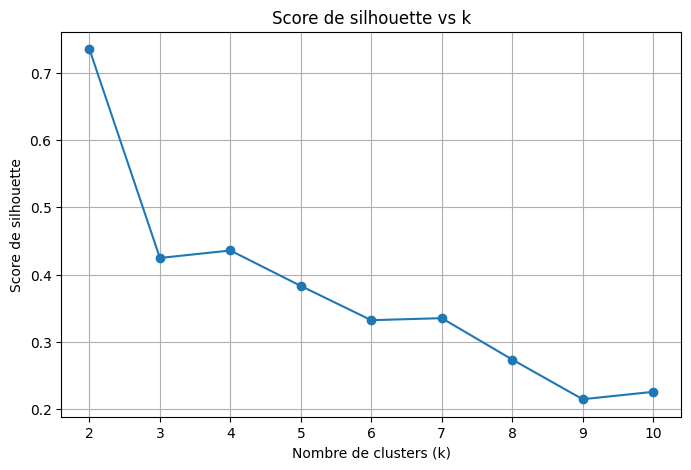

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker="o")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Score de silhouette")
plt.title("Score de silhouette vs k")
plt.grid(True)
plt.show()


## Tableau récapitulatif

In [21]:
import pandas as pd

results_k = pd.DataFrame({
    "k": list(K),
    "inertia": inertias,
    "silhouette_score": silhouette_scores
})

results_k


,k,inertia,silhouette_score
0,2,654543.425409,0.734804
1,3,527491.109967,0.424789
2,4,411652.486594,0.435898
3,5,356663.114450,0.383234
4,6,321900.690176,0.332369
5,7,292324.366013,0.335405
6,8,270294.666547,0.273963
7,9,251104.484538,0.215004
8,10,236514.262352,0.225955


## Conclusion

Le nombre de clusters a été déterminé à l’aide de la méthode du coude
et du score de silhouette. Le choix final repose sur un compromis entre
qualité de segmentation et interprétabilité métier.

Le nombre de clusters a été déterminé à l’aide de la méthode du coude et du score de silhouette.
Bien que k=2 présente un score de silhouette élevé, cette segmentation est trop grossière d’un point de vue métier.
Le choix de k=4 représente un compromis optimal entre qualité statistique, stabilité des clusters et interprétabilité business


# 4.3 — Création et interprétation des segments clients

# Entraînement du KMeans (k = 4)

In [22]:
from sklearn.cluster import KMeans

kmeans_final = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

client_features["cluster"] = kmeans_final.fit_predict(X_scaled)


In [23]:
client_features["cluster"].value_counts().sort_index()


cluster
0    70479
1      768
2    15188
3     6923
Name: count, dtype: int64

# Analyse des profils moyens par cluster

In [24]:
cluster_profile = (
    client_features
    .groupby("cluster")[segmentation_vars]
    .mean()
    .round(2)
)

cluster_profile


,recency,frequency,monetary,avg_basket,total_items,avg_delivery_delay,avg_review_score,nb_categories
cluster,,,,,,,,
0,235.41,1.03,114.13,111.16,1.12,10.22,4.67,1.02
1,242.89,1.03,1820.73,1786.18,1.64,14.32,3.97,1.02
2,243.60,1.03,135.61,132.38,1.26,20.28,1.77,1.03
3,237.24,1.08,566.32,541.66,1.55,13.13,4.19,1.06


# Taille des clusters (importance stratégique)

In [25]:
cluster_sizes = (
    client_features["cluster"]
    .value_counts(normalize=True)
    .sort_index()
    .round(3)
)

cluster_sizes


cluster
0    0.755
1    0.008
2    0.163
3    0.074
Name: proportion, dtype: float64

# Visualisation simple

In [26]:
# PCA 2D

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2"]
)
pca_df["cluster"] = client_features["cluster"]


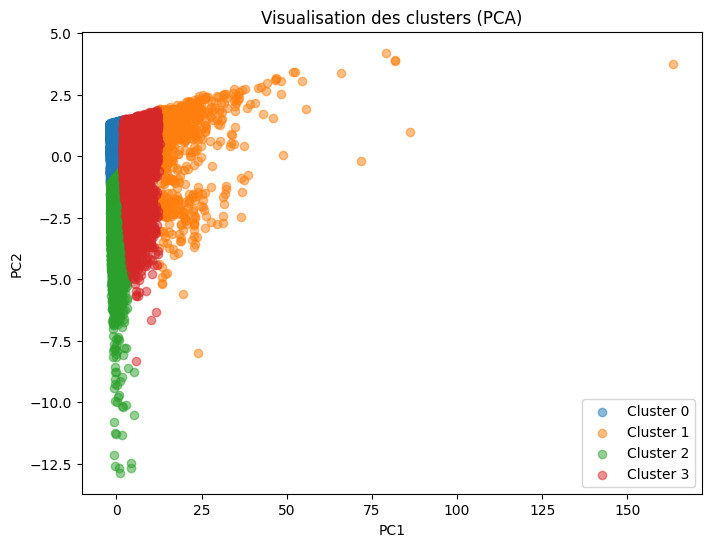

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for c in sorted(pca_df["cluster"].unique()):
    subset = pca_df[pca_df["cluster"] == c]
    plt.scatter(subset["PC1"], subset["PC2"], label=f"Cluster {c}", alpha=0.5)

plt.legend()
plt.title("Visualisation des clusters (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


La projection PCA en deux dimensions confirme la cohérence globale de la segmentation, en mettant en évidence des groupes de clients distincts en termes de valeur et d’expérience, tout en montrant un chevauchement naturel entre profils intermédiaires.

In [28]:
client_features.to_parquet(
    INTERIM_DIR / "client_features_with_clusters.parquet",
    index=False
)
